In [1]:
import setup

task_matrix, tstat_task_matrix, masker = setup.setup_mdtb('block', is_setup_block=True)
zscored_task_matrix = setup.zscore_subject_2d(task_matrix)

conditions_matrix, tstat_conditions_matrix, masker = setup.setup_mdtb('_norest', is_setup_block=False)
zscored_conditions_matrix = setup.zscore_subject_2d(conditions_matrix)

loading sub 02
loading sub 03
loading sub 04
loading sub 06
loading sub 09
loading sub 12
loading sub 14
loading sub 15
loading sub 17
loading sub 18
loading sub 19
loading sub 20
loading sub 21
loading sub 22
loading sub 24
loading sub 25
loading sub 26
loading sub 27
loading sub 28
loading sub 30
loading sub 31
0.3389675794224004
2.9467822197039144
3.665498240032263e-19
loading sub 02
loading sub 03
loading sub 04
loading sub 06
loading sub 09
loading sub 12
loading sub 14
loading sub 15
loading sub 17
loading sub 18
loading sub 19
loading sub 20
loading sub 21
loading sub 22
loading sub 24
loading sub 25
loading sub 26
loading sub 27
loading sub 28
loading sub 30
loading sub 31
-0.366938125009494
3.6509001173588116
-3.772016992306705e-17


In [53]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import pandas as pd

from thalpy.constants import paths

MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
stim_config_df = pd.read_csv(MDTB_DIR + paths.DECONVOLVE_DIR + paths.STIM_CONFIG)
CONDITIONS_LIST = stim_config_df["Stim Label"].tolist()
TASK_LIST = list(set(stim_config_df["Group"].to_list()))

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hier_cluster(task_matrix, n_clusters=None):
    if n_clusters is None:
        distance_threshold = 0
    else:
        distance_threshold = None
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    cluster = model.fit(np.mean(task_matrix, axis=2).swapaxes(0, 1))
    if distance_threshold is not None:
        plot_dendrogram(model, truncate_mode='level', p=3)
    return cluster

# try No clusters first
# task_cluster = hier_cluster(zscored_task_matrix)

# try 15, 5

conditions_cluster = hier_cluster(zscored_conditions_matrix, n_clusters=7)

for k in np.arange(len(np.unique(conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(CONDITIONS_LIST) if k == conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')




k: 0  group: ['NatureMovie', 'AnimatedMovie', 'VideoActions', 'Rest']
k: 1  group: ['Go', 'SpatialMapMed', 'SpatialMapHard', 'MentalRotHard', 'RespAltEasy', 'RespAltMed', 'RespAltHard', 'FingerSeq']
k: 2  group: ['DigitJudgement', 'IntervalTiming', 'MotorImagery', 'StroopIncon', 'StroopCon', 'Verbal2Back', 'SpatialImagery', 'WordRead']
k: 3  group: ['LandscapeMovie', 'MentalRotEasy', 'MentalRotMed', 'BiologicalMotion', 'ScrambledMotion', 'VideoKnots', 'VisualSearchHard']
k: 4  group: ['UnpleasantScenes', 'PleasantScenes', 'Objects', 'SadFaces', 'HappyFaces']
k: 5  group: ['NoGo', 'Math', 'SpatialMapEasy', 'PermutedRules', 'Prediction', 'PredictViol', 'PredictScram', 'FingerSimple', 'Object2Back', 'VisualSearchEasy', 'VisualSearchMed']
k: 6  group: ['TheoryOfMind', 'VerbGen']


/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


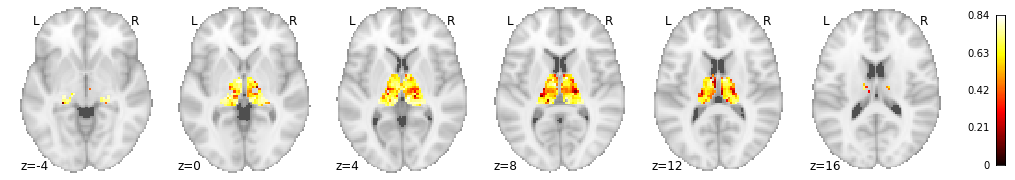

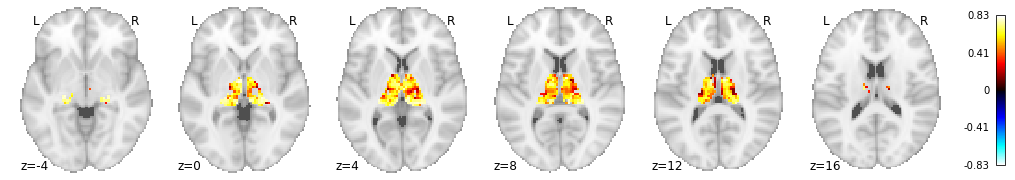

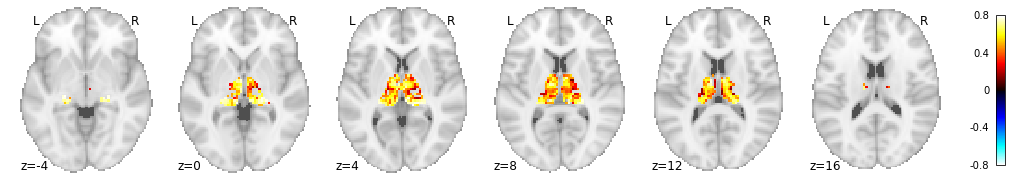

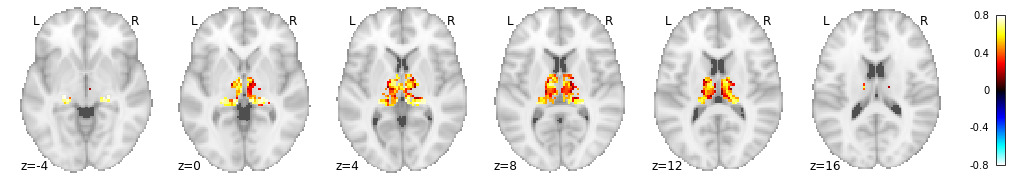

In [54]:
from thalpy.analysis import pc, plotting

thresholds = [70, 75, 80, 85]
pc_matrix = pc.pc_subject(np.mean(zscored_conditions_matrix, axis=2), conditions_cluster.labels_, thresholds=thresholds)

for i, threshold in enumerate(thresholds):
    pc_img = masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img)